In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io 
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, glob, cv2

# packages needed for making a dataset: 
from torch.utils.data import DataLoader
from torchvision import transforms

from diffuser_utils import *
import dataset as ds
import models.spectral_model as sm
import models.machinelearning_forward as fm

from datetime import date, datetime

import sys
sys.path.append("..")

from models.unet import Unet
import models.unet3d as unet3d


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import dataset_helper_functions.read_pca_data as rpca
import csv

os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3" #choose the number of gpu that's free. It goes from 0-3

device = 'cuda:0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# pull ds into fruitset
fruitset_pca = glob.glob('. ./DefocusCamData/sample_data/fruitdata/pca/*.mat')
fruitset_cspace = glob.glob('. ./DefocusCamData/sample_data/fruitdata/cspaces/*.mat')
apple = glob.glob('. ./DefocusCamData/sample_data/fruit/*.mat')
all_files_summer = glob.glob('/home/kyanny_waller/summerResearch/CZ_hsdb/*.mat')
paviaU = glob.glob('. ./DefocusCamData/sample_data/PaviaU.mat')


In [12]:
### load pavia image
pavia_test_data = ds.SpectralDataset(paviaU, transforms.Compose([ds.subImageRand(),
                                                                   ds.chooseSpectralBands(), 
                                                                   ds.Normalize(), 
                                                                   ds.toTensor()]), tag = 'paviaU')
print(len(pavia_test_data))
pavia_sample = pavia_test_data.__getitem__(0)
print(pavia_sample['image'].shape)
pavia_np = pavia_sample['image'].numpy().transpose(1,2,0)

inds = [0,5,10,15,20,25,29]
fig, ax = plt.subplots(1,len(inds), figsize = (20,5))

for i in range(0,len(inds)):
    ax[i].imshow(pavia_np[...,inds[i]], cmap = 'RdBu')
    ax[i].set_title(f"Slice: {inds[i]}")
#load fruit pca data
fruit_train_data = ds.SpectralDataset(fruitset_pca, transforms.Compose([ds.readCompressed(),
                                                                       ds.Resize(),
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(), 
                                                                       ds.Normalize(), 
                                                                       ds.toTensor()]))
summer_train_data = ds.SpectralDataset(all_files_summer, transforms.Compose([ds.Resize(), 
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(),
                                                                       ds.Normalize(),
                                                                       ds.toTensor()]), tag = 'ref')
train_data = ds.Wrapper([summer_train_data, fruit_train_data])
#print(fruitset_pca)
#print(fruit_train_data.img_dir)
for j in range(3):
    fruit_sample = fruit_train_data.__getitem__(j)
    fruit_np = fruit_sample['image'].numpy().transpose(1,2,0)

    fig2, ax2 = plt.subplots(1,len(inds), figsize = (20,5))
    for i in range(0,len(inds)):
        ax2[i].imshow(fruit_np[...,inds[i]])
        ax2[i].set_title(f"Slice: {inds[i]}; {fruit_np[...,inds[i]].shape}")
        
for j in range(40,45):
    train_sample = train_data.__getitem__(j)
    train_np = train_sample['image'].numpy().transpose(1,2,0)

    fig2, ax2 = plt.subplots(1,len(inds), figsize = (20,5))
    for i in range(0,len(inds)):
        ax2[i].imshow(train_np[...,inds[i]])
        ax2[i].set_title(f"Slice: {inds[i]}; {train_np[...,inds[i]].shape}")


0


IndexError: list index out of range

In [4]:
!gpustat

/bin/bash: gpustat: command not found


In [5]:
# define fwd model
mask = load_mask()
num_images = len(fruit_train_data)
num_inputs_simult = 2
blur_type = 'asymmetric'
optimize_blur = False
forward_model = fm.Forward_Model(mask, num_ims = num_inputs_simult, blur_type = blur_type)

optimize blur False


In [6]:
#forward model working check 
fruit_dataloader = DataLoader(fruit_train_data, batch_size = 1, shuffle = True)
train_dataloader = DataLoader(train_data, batch_size = 1, shuffle = True)



image_tensor shape: torch.Size([1, 30, 256, 256])
simulated_meas shape: torch.Size([1, 2, 30, 256, 256])
image np shape: (256, 256, 30)


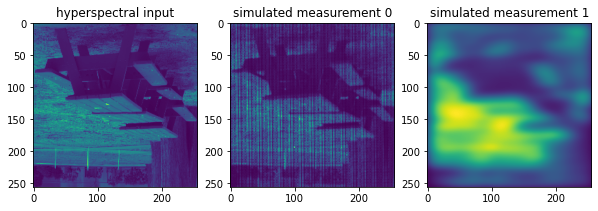

In [7]:
for i, sample in enumerate(train_dataloader): 
    image_tensor = sample['image']
    print('image_tensor shape:', image_tensor.shape)
    simulated_meas = forward_model(image_tensor.to(device))
    print('simulated_meas shape:', simulated_meas.shape)
    '''
    ## ADJ TESTING ##
    #get the mask from model as tensor
    mask = forward_model.mask_var
    sim = torch.unsqueeze(simulated_meas, 2)
    print(sim.shape)
    #get the individual measurements
    flat = simulated_meas[0]
    sm1, sm2 = flat[0], flat[1]
    print('smsize', sm1.shape)
    
    s0, s1 = forward_model.PAD_SIZE0//2, forward_model.PAD_SIZE1//2
    pad = (s0, s0, s1, s1)
    #pad
    sm1 = F.pad(sm1, pad, 'constant', 0)
    #fft
    sm1c = torch.complex(sm1, torch.zeros_like(sm1))
    sm1c = torch.unsqueeze(sm1c,0)
    sm1c = torch.fft.fft2(sm1c)#torch.fft.ifftshift()
    
    blur1, blur2 = torch.tensor(forward_model.psf[0]), torch.tensor(forward_model.psf[1])
    blur1 = F.pad(blur1.clone().detach(), pad, 'constant', 0)
    blur1 = torch.unsqueeze(torch.conj(torch.complex(blur1, torch.zeros_like(blur1))),0)
    blur1fft = torch.fft.fft2(blur1.to(device='cuda:0'))#torch.fft.ifftshift()
    
    final_meas = torch.fft.fftshift(torch.fft.ifft2(blur1fft*sm1c))#torch.fft.fftshift()
    plt.imshow(torch.abs(final_meas[0]).detach().cpu().numpy())
    print(type(final_meas.double()))
    ## END ADJ TESTING ##'''
    
    image_np = image_tensor[0].numpy().transpose(1,2,0)
    print(f"image np shape: {image_np.shape}")
    
    fig, ax = plt.subplots(1,1 + num_inputs_simult, figsize = (10, 20))
    ax[0].imshow(np.mean(image_np,-1)); 
    ax[0].set_title('hyperspectral input')
    for j in range(0,num_inputs_simult):
        ax[1+j].imshow(np.mean(simulated_meas[0].detach().cpu().numpy()[j].transpose(1,2,0), -1))
        ax[1+j].set_title('simulated measurement '+ str(j))
    plt.show()
    if i == 0:
        break

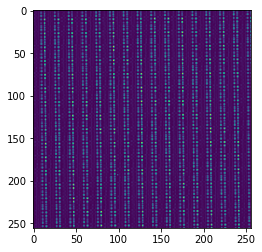

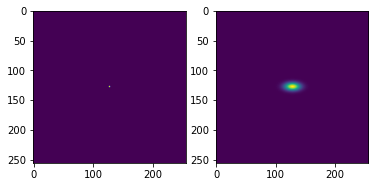

In [8]:
plt.imshow(mask[...,10])

fig, ax = plt.subplots(1,num_inputs_simult)
for j in range(0,num_inputs_simult):
    ax[j].imshow(forward_model.psf[j]); 

In [9]:
#Train model
#1.) make save folder
args_dict = {'number_measurements': str(num_inputs_simult),
        'blur_type': blur_type,
         'optimize_blur': str(optimize_blur)}
save_folder = 'saved_models/checkpoint_'+"_".join(list(args_dict.values())) + '/'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

#2.) define model 
recon_model = unet3d.Unet(n_channel_in=num_inputs_simult, n_channel_out=1) # Recon model, gets out image from measurement
recon_model.to(device);
model = sm.MyEnsemble(forward_model.to(device), recon_model.to(device))
if optimize_blur == False:
    model.model1.w_blur.requires_grad = False

#3.) define loss parameters
from torch.nn import MSELoss, L1Loss, CosineSimilarity
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = L1Loss() 
optimizer = Adam(model.parameters(), lr=0.001)

# PROBLEM: this should print out at least 1 thing, the blur.
#for param in model.parameters():
   # if param.requires_grad:
        #print(param.data)
        
print(model.model1.w_blur)
print(model.model1.w_blur.requires_grad)
#run model
epochs = 1000
w_list, loss_list, test_loss_list = [], [], []


Parameter containing:
tensor([[0.0020, 0.0010],
        [0.1000, 0.0500]], device='cuda:0')
False


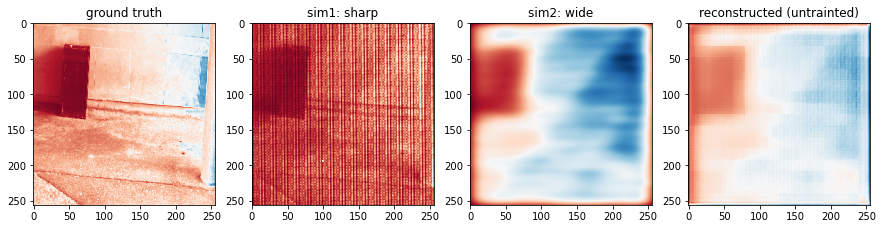

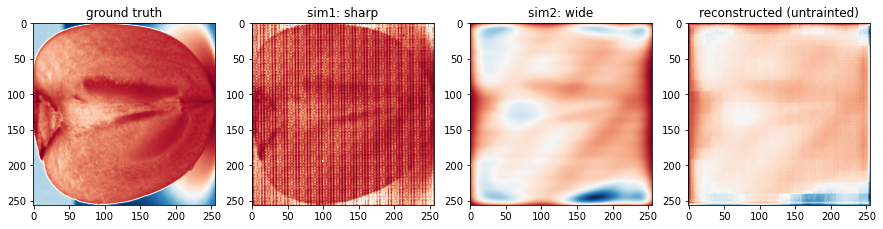

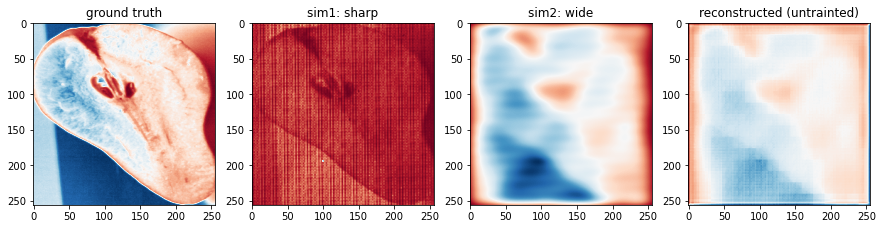

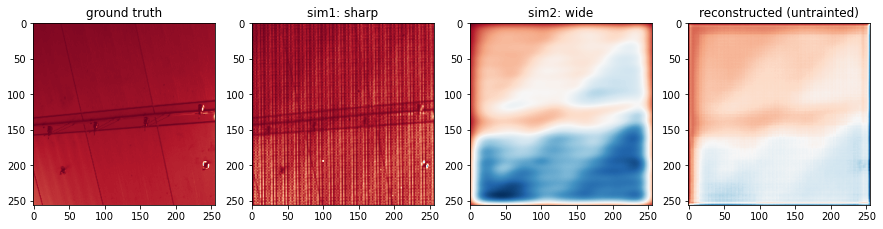

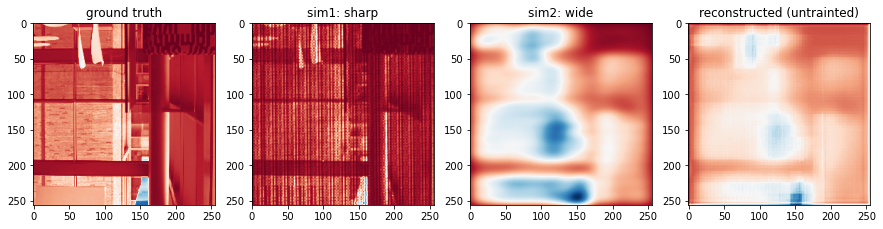

In [11]:
h = 0
for sample in train_dataloader:
    h += 1
    if h > 5:
        break
    base = sample['image'].to(device)
    forward = forward_model(base)
    output = model(base)
    
    fig, ax = plt.subplots(1,4,figsize = (15,5))
    ax[0].imshow(np.mean(base.detach().cpu().numpy()[0],0), cmap = 'RdBu')
    ax[0].set_title('ground truth')
    ax[1].imshow(np.mean(forward.detach().cpu().numpy()[0][0], 0), cmap = 'RdBu')
    ax[1].set_title('sim1: sharp')
    ax[2].imshow(np.mean(forward.detach().cpu().numpy()[0][1],0), cmap = 'RdBu')
    ax[2].set_title('sim2: wide')
    ax[3].imshow(np.mean(output.detach().cpu().numpy()[0][0],0), cmap = 'RdBu')
    ax[3].set_title('reconstructed (untrainted)')

In [12]:
#Define pavia data as test data. 
#The goal here is to see how the model performs on test data with a lot of detail, when trained
#on datasets that are pretty gradient-sparse
pavia_dataloader = DataLoader(pavia_test_data, batch_size=1, shuffle=True)

def run_test():
    test_loss = 0
    sample_np = None
    for sample in pavia_dataloader:
        sample_np = sample['image'].numpy()[0]
        output = model(sample['image'].to(device))   # Compute the output image 
        loss = loss_function(output, sample['image'].to(device)) # Compute the loss
        test_loss += loss.item()
    test_loss = test_loss/pavia_dataloader.__len__()
    test_np = output.detach().cpu().numpy()[0]
        
    return test_loss, test_np, sample_np


Total Train Loss ( 0 ): 0.1782  	 Blur: [[0.002 0.001]
 [0.1   0.05 ]]


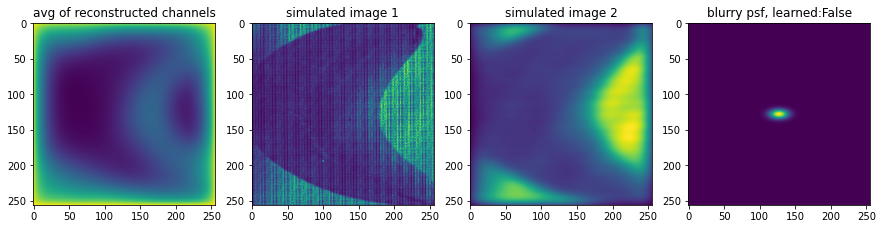

Total Train Loss ( 1 ): 0.1342  	 Blur: [[0.002 0.001]
 [0.1   0.05 ]]


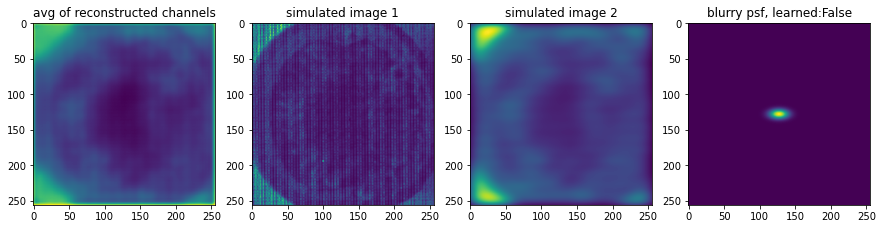

Total Train Loss ( 2 ): 0.1338  	 Blur: [[0.002 0.001]
 [0.1   0.05 ]]


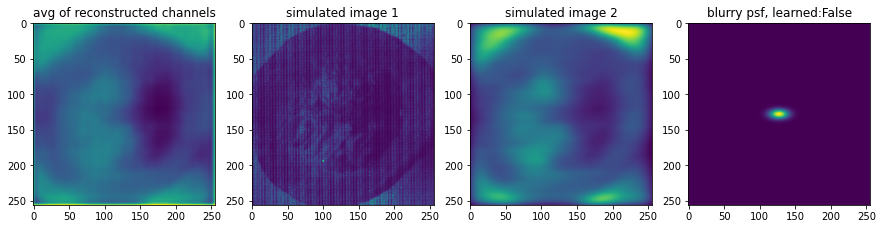

Total Train Loss ( 3 ): 0.1338  	 Blur: [[0.002 0.001]
 [0.1   0.05 ]]


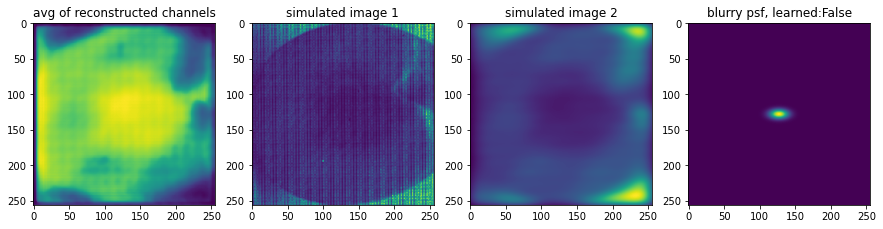

Total Train Loss ( 4 ): 0.1672  	 Blur: [[0.002 0.001]
 [0.1   0.05 ]]


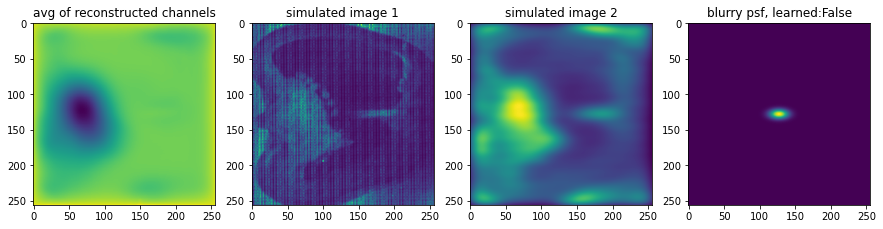

In [ ]:
for i in range(epochs):
    train_loss = 0
    k = 0
    
    post_forward_np_list = []
    post_recon_np_list = []
    
    for sample in fruit_dataloader:
        k += 1
        optimizer.zero_grad() #doing this first to initialize gradients to 0
        
        base = sample['image'].to(device)
        output = model(base)
        
        base_padded = model.spectral_pad(base, 1)
        output = output[0]
        loss = loss_function(output, base_padded)
        train_loss += loss.item()

        loss.backward()
        
        #NaN gradients can be detected -> set to 0
        optimizer.step()
        
        model.model1.w_blur.data = torch.clip(model.model1.w_blur.data, .0006, 1)
        #we can enforce a constraint... but right now it is just stopping at this edge ^

        post_forward_np_list.append(model.output1.detach().cpu().numpy()[0])
        post_recon_np_list.append(output.detach().cpu().numpy()[0])
        
    
    loss_per_sample = train_loss / fruit_dataloader.__len__()
    loss_list.append(loss_per_sample)
    
    #testing
    test_loss = 0
    if i % 10 == 0 and not i == 0:
        test_loss, test_np, ground_truth_np = run_test()
        test_loss_list.append(test_loss)
        
        #show test recon next to ground truth
        print("Total Test Loss (", i, "): \t", round(test_loss_list[-1], 4))
        fig,ax = plt.subplots(1,2,figsize = (15,5))
        ax[0].imshow(np.mean(test_np, 0), cmap = 'RdBu')
        ax[0].set_title('reconstructed')
        ax[1].imshow(np.mean(ground_truth_np,0), cmap = 'RdBu')
        ax[1].set_title('ground truth')
        
        plt.show()
        
        
    #show train recon next to masks
    print("Total Train Loss (", i, "):", round(loss_list[-1], 4),
         " \t Blur:", model.model1.w_blur.data.detach().cpu().numpy())
    fig, ax = plt.subplots(1,num_inputs_simult+2, figsize = (15,5))
    ax[0].imshow(np.mean(post_recon_np_list[-1],0)) #np.mean(a,0) averages spec channels
    ax[0].set_title('avg of reconstructed channels')
    for j in range(0,num_inputs_simult):
        ax[j+1].imshow(np.mean(post_forward_np_list[-1][j],0))
        ax[j+1].set_title(f'simulated image {j+1}')
    ax[-1].imshow(model.model1.psf[1]) #blurry psf
    ax[-1].set_title(f'blurry psf, learned:{optimize_blur}')
    plt.show()
    
    
    if i % 10 == 0 and not i == 0:
        torch.save(model.state_dict(), save_folder + 'saved_model_' 'ep'+str(i)+'_testloss_'+str(test_loss) + '.pt')
        scipy.io.savemat(save_folder+'saved_lists.mat', 
                         {'test_loss': test_loss_list,
                         'train_loss': loss_list,
                         'w_list': w_list})
    
          